In [1]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt



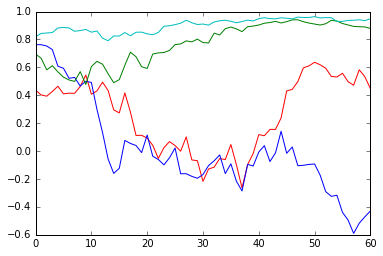

In [2]:
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   


#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,100), range(0,100)):
        x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 100, 100))
    for (i, j) in product (range(0,100), range(0,100)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.1)


#Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][97][95])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [3]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns


#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    
    
    
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x


#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 0
        boundary1 = range_of_sample
    if (sample_or_not=='out_of_sample'):
        boundary0 = N_samples - range_of_sample
        boundary1 = N_samples
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)


#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun




In [5]:
times = []
results = []
sample_error = []
out_of_sample_error = []
range_of_sample = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
sigma_values = np.linspace(0.05, 0.3, 10)
N_samples = np.max(range_of_sample) + 200
for sigma in sigma_values:
    daily_corr = daily_correlation(sigma)
    m0, m1, r1 = empiric_models(N_samples, daily_corr)
    local_results, local_sample_error, local_times, local_out_of_sample_error = [], [], [], []
    for sample in range_of_sample:
        time, result, err = optimal_model_weights(sample)
        local_sample_error.append(err)
        local_results.append([result[0], result[1], 1-result[0]-result[1]])
        local_times.append(time)
        print time, result, err
        e = error(result, 'out_of_sample', 200)
        local_out_of_sample_error.append(e)
        print e
    times.append(local_results)
    results.append(local_results)
    sample_error.append(local_sample_error)
    out_of_sample_error.append(local_out_of_sample_error)



C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\Mikhail\Anaconda2\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]


0:05:53.262000 [ 0.8097891  0.1902109] 0.0129232301086
0.0157521896007
0:12:01.243000 [ 0.80830611  0.19169389] 0.0133475135661
0.0157536823838
0:16:44.192000 [ 0.71503095  0.28425368] 0.0141068375507
0.0155112395381
0:20:54.267000 [ 0.73765833  0.26234167] 0.0142632737032
0.0155366775053
0:28:48.130000 [ 0.7376678  0.2623322] 0.0144272055938
0.0155366840089
0:37:11.178000 [ 0.71525722  0.28460136] 0.0149260293916
0.015514069607
0:43:24.259000 [ 0.71525691  0.28460166] 0.0151061724152
0.0155140694526
0:45:40.559000 [ 0.71401702  0.28598298] 0.0148054564183
0.0155137630565
0:55:49.327000 [ 0.71387559  0.28612441] 0.0145432352358
0.0155137736032
1:01:01.719000 [ 0.71525706  0.28460152] 0.0143816334391
0.0155140695281
1:05:34.133000 [ 0.71405523  0.28594477] 0.0142624292483
0.0155137822743
1:17:52.781000 [ 0.70942725  0.29043133] 0.0141765567039
0.0155118123716
0:05:41.428000 [ 0.51110195  0.48889805] 0.0184158471293
0.0183375749209
0:11:06.116000 [ 0.77550647  0.22435211] 0.0183368028512

In [8]:
print times
print results
print sample_error
print out_of_sample_error

[[[0.80978910450157793, 0.19021089549842213, -5.5511151231257827e-17], [0.80830611375619099, 0.19169388624380904, -2.7755575615628914e-17], [0.71503094888263163, 0.28425368406178009, 0.00071536705558827851], [0.73765833016262428, 0.26234166983737572, 0.0], [0.73766780359717343, 0.26233219640282662, -5.5511151231257827e-17], [0.71525722399808067, 0.28460135907983281, 0.00014141692208652357], [0.71525691458255691, 0.2846016649613955, 0.00014142045604759179], [0.71401701526158801, 0.28598298473841188, 1.1102230246251565e-16], [0.71387559390535082, 0.28612440609464923, -5.5511151231257827e-17], [0.71525706131939126, 0.28460151956861351, 0.00014141911199522239], [0.71405523415966932, 0.28594476584033074, -5.5511151231257827e-17], [0.70942725037272603, 0.29043133381192415, 0.00014141581534982128]], [[0.51110195207023867, 0.48889804792976133, 0.0], [0.77550647280426821, 0.22435211314613995, 0.00014141404959183701], [0.77600469466192645, 0.22386136823911645, 0.00013393709895709316], [0.7784046

For sigma = 0.05:


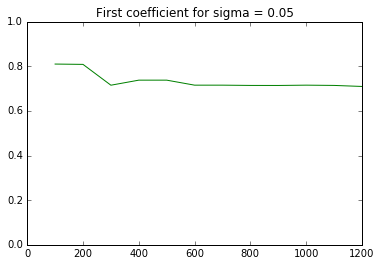

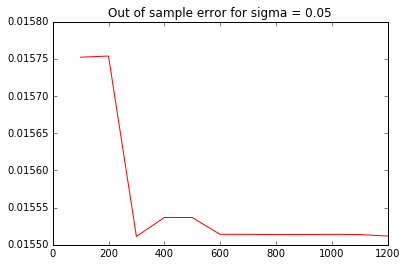

For sigma = 0.0777778:


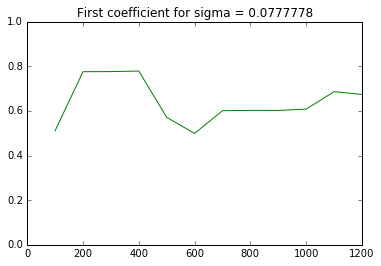

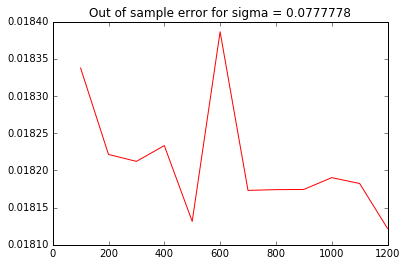

For sigma = 0.105556:


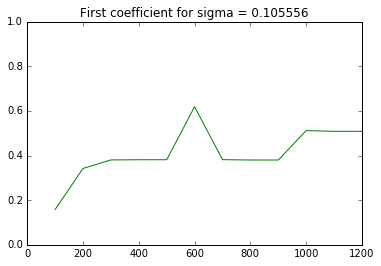

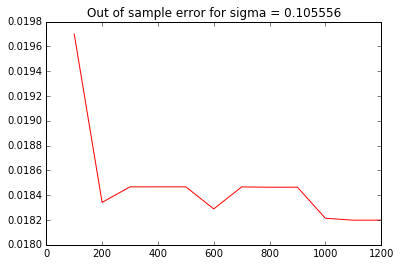

For sigma = 0.133333:


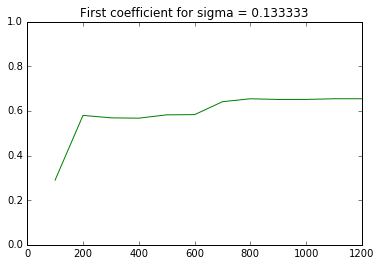

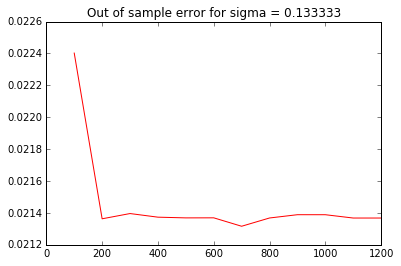

For sigma = 0.161111:


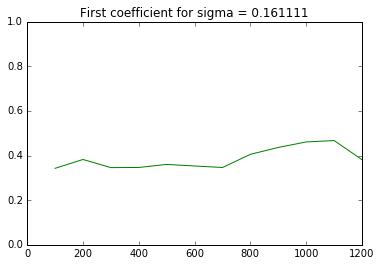

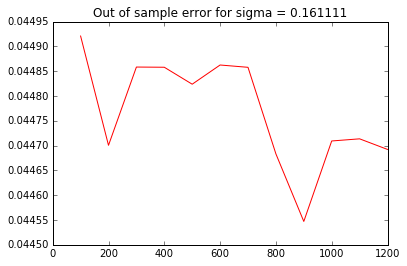

For sigma = 0.188889:


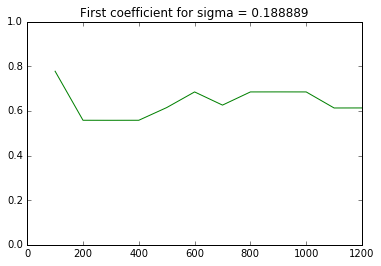

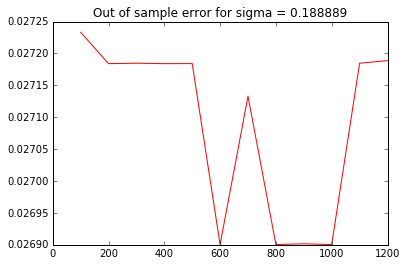

For sigma = 0.216667:


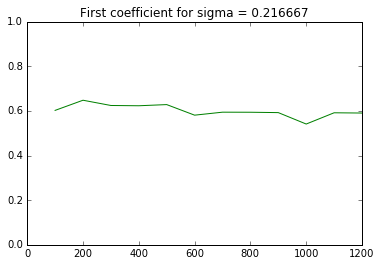

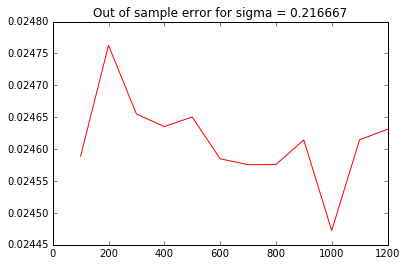

For sigma = 0.244444:


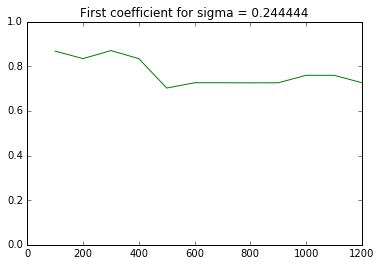

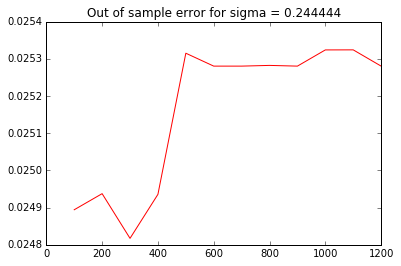

For sigma = 0.272222:


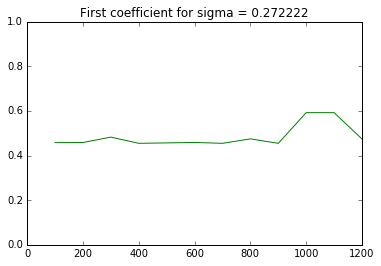

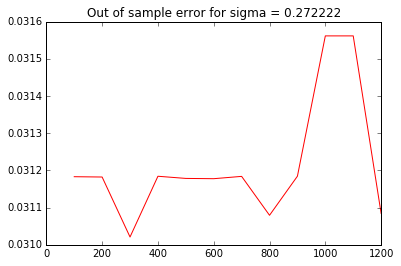

For sigma = 0.3:


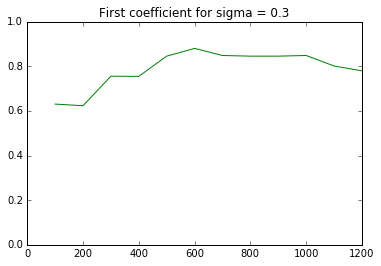

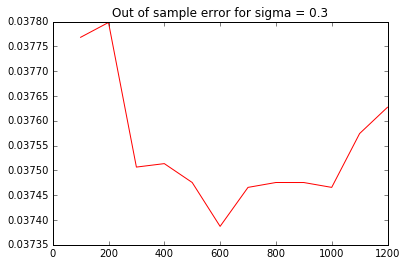

In [12]:
for j in range(0,10):
    first_coef = []
    print 'For sigma = %lg:' %sigma_values[j]
    for i in range(0, len(range_of_sample)):
        first_coef.append(results[j][i][0])
    plt.plot(range_of_sample, first_coef, 'g')
    plt.ylim([0., 1.])
    plt.title('First coefficient for sigma = %lg' %sigma_values[j])
    plt.show()
    plt.plot(range_of_sample, out_of_sample_error[j], 'r')
    plt.title('Out of sample error for sigma = %lg' %sigma_values[j])
    plt.show()



In [ ]:
def stump(models, sigma_values, weights_for_models):
    main_sigmas = sigma_values.sort()

In [7]:
a = [-0.9, -0.567, 0.57, 0.578, 1000, -200, 5, 2.5]
a = np.sort(a)
print a

[ -2.00000000e+02  -9.00000000e-01  -5.67000000e-01   5.70000000e-01
   5.78000000e-01   2.50000000e+00   5.00000000e+00   1.00000000e+03]
